# Exploratory Data Analysis
### Kwame V. Taylor

## Set up Environment

In [1]:
import pandas as pd
import numpy as np

from math import sqrt
from scipy import stats

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib as mpl
import seaborn as sns
from cycler import cycler

# default viz size settings
sns.set(rc={'figure.figsize':(12, 9)})
sns.set_context("talk", rc={"font.size":14,"axes.titlesize":16,"axes.labelsize":12}) 
plt.rc('figure', figsize=(12, 9))
plt.rc('font', size=14)
mpl.rcParams['font.size'] = 14
mpl.rcParams['figure.figsize'] = 12, 9
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '--'
mpl.rcParams['axes.prop_cycle'] = cycler(color=['deepskyblue', 'firebrick', 'darkseagreen', 'violet'])

In [2]:
from prepare import handle_nulls, fix_tempo, set_index, prepare_df, change_dtypes
from preprocessing import spotify_split, scale_data

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Acquire data

In [4]:
df = pd.read_csv('my_spotify.csv', index_col=0)

In [5]:
df.head()

,artist,album,release_date,track_name,track_id,album_popularity,label,danceability,energy,key,...,valence,tempo,duration_ms,time_signature,explicit,popularity,disc_number,track_number,album_id,album_type
0,Tay-K,TRAPMAN,2020-07-12,TRAPMAN,6mecZbKK3JDeMdFRNxsCV5,36,Tay-K,0.792,0.594,2.0,...,0.351,82.512,232803.0,4.0,True,43.0,1.0,1.0,2J1hMj78HfdcMrmL2Sk6eR,single
1,Lil Wyte,Doubt Me Now,2003-03-04,Oxy Cotton,5PtMwNq8Dp31uYdGGacVJE,55,Hypnotize Minds Productions,0.816,0.578,9.0,...,0.265,148.077,193920.0,4.0,True,61.0,1.0,11.0,2lwxcemR1muymEHNMblCpm,album
2,Kamelen,KINGPIN SLIM,2019-11-29,Kingpin O.G - Remix,6s8EhlBn2PIoESylkXnwYc,46,NMG/G-HUSET,0.649,0.798,0.0,...,0.717,160.011,254390.0,4.0,True,23.0,1.0,11.0,6va2RTYO2ois7t88RN0LhJ,album
3,Waka Flocka Flame,Flockaveli,2010-10-01,Grove St. Party (feat. Kebo Gotti),2e9EZ2V5QGGZPMJacO3y0Y,71,Asylum/Warner Records,0.705,0.702,0.0,...,0.771,140.059,250493.0,4.0,True,62.0,1.0,9.0,6MQtWELG7aRX7CkAzQ6nLM,album
4,Project Pat,Mista Don't Play: Everythangs Workin',2001-02-13,Don't Save Her (feat. Crunchy Black),3ZRd5Z0fiYtASLdEPPb16m,55,Hypnotize Minds Productions,0.838,0.793,11.0,...,0.800,160.003,261933.0,4.0,True,45.0,1.0,5.0,4QzaueQPQa0lqrMmQoh4v0,album


In [6]:
# join the dataframes
genre = pd.read_csv('genre_count_df.csv')
genre = set_index(genre)
genre = genre[genre.columns[32:]]
#genre = genre.drop_duplicates(subset=['trackid'])
#df = df.drop_duplicates(subset=['trackid'])
df = df.merge(genre, on='track_id', suffixes=[None, ''])
df = df.dropna()

In [7]:
df.head()

,artist,album,release_date,track_name,track_id,album_popularity,label,danceability,energy,key,...,west coast rap,west coast trap,winnipeg hip hop,witch house,wonky,worship,wrestling,wu fam,zambian hip hop,zouk riddim
0,Tay-K,TRAPMAN,2020-07-12,TRAPMAN,6mecZbKK3JDeMdFRNxsCV5,36,Tay-K,0.792,0.594,2.0,...,0,0,0,0,0,0,0,0,0,0
1,Lil Wyte,Doubt Me Now,2003-03-04,Oxy Cotton,5PtMwNq8Dp31uYdGGacVJE,55,Hypnotize Minds Productions,0.816,0.578,9.0,...,0,0,0,0,0,0,0,0,0,0
2,Kamelen,KINGPIN SLIM,2019-11-29,Kingpin O.G - Remix,6s8EhlBn2PIoESylkXnwYc,46,NMG/G-HUSET,0.649,0.798,0.0,...,0,0,0,0,0,0,0,0,0,0
3,Waka Flocka Flame,Flockaveli,2010-10-01,Grove St. Party (feat. Kebo Gotti),2e9EZ2V5QGGZPMJacO3y0Y,71,Asylum/Warner Records,0.705,0.702,0.0,...,0,0,0,0,0,0,0,0,0,0
4,Project Pat,Mista Don't Play: Everythangs Workin',2001-02-13,Don't Save Her (feat. Crunchy Black),3ZRd5Z0fiYtASLdEPPb16m,55,Hypnotize Minds Productions,0.838,0.793,11.0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
df.shape

(5733, 410)

In [9]:
df.columns

Index(['artist', 'album', 'release_date', 'track_name', 'track_id',
       'album_popularity', 'label', 'danceability', 'energy', 'key',
       ...
       'west coast rap', 'west coast trap', 'winnipeg hip hop', 'witch house',
       'wonky', 'worship', 'wrestling', 'wu fam', 'zambian hip hop',
       'zouk riddim'],
      dtype='object', length=410)

In [10]:
df.isna().sum()

artist             0
album              0
release_date       0
track_name         0
track_id           0
                  ..
worship            0
wrestling          0
wu fam             0
zambian hip hop    0
zouk riddim        0
Length: 410, dtype: int64

## Prepare data

In [11]:
# rearrange columns for focused and easy viewing and exploration

# drop for now: 'album_id', 'album_popularity', 'release_year', 'release_month',
# 'release_day', 'duration_ms'

#df = df[['popularity', 'artist', 'album', 'track_name',
#       'label', 'danceability', 'energy', 'key', 'loudness', 'mode', 'is_featured_artist',
#       'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'explicit',
#       'disc_number', 'duration_minutes', 'track_number', 'album_type', 'release_date']]
#df

# I'll redo this code once all of our code is solidified.

In [12]:
# take a look at 'key' audio feature
df.key.value_counts()

1.0     1150
11.0     592
7.0      502
10.0     487
2.0      482
6.0      476
0.0      459
8.0      430
9.0      406
4.0      332
5.0      318
3.0       99
Name: key, dtype: int64

In [13]:
# all prepare functions
df = prepare_df(df)

# rename 'key' values (no pun intended)
df.key = df.key.map({0: 'C', 1: 'C♯', 2: 'D', 3: 'D♯', 4: 'E', 5: 'F', 6: 'F♯', 7: 'G', 8: 'G♯', 9: 'A', 10: 'B♭', 11: 'B'})

# map 'mode' into major and minor
df['mode'] = df['mode'].map({0: 'Minor', 1: 'Major'})

# split the data
X_train, y_train, X_validate, y_validate, X_test, y_test, train, validate, test = spotify_split(df, 'popularity')
train.head()

Shape of train: (4012, 416) | Shape of validate: (861, 416) | Shape of test: (860, 416)
Percent train: 70.0        | Percent validate: 15.0       | Percent test: 15.0


,release_year,release_month,release_day,artist,album,release_date,track_name,album_popularity,label,danceability,...,worship,wrestling,wu fam,zambian hip hop,zouk riddim,duration_seconds,duration_minutes,is_featured_artist,decade,is_top_billboard_label
track_id,,,,,,,,,,,,,,,,,,,,,
30bqVoKjX479ab90a8Pafp,2019,04,19,lil peep,star shopping,2019-04-19,star shopping,80,Lil Peep,0.585,...,0,0,0,0,0,142,2,0,2010s,0
0HO8pCseEpgozNi3z0R4bc,2015,03,17,father,who's gonna get fucked first?,2015-03-17,everybody in the club gettin shot,26,Awful Records,0.833,...,0,0,0,0,0,120,2,0,2010s,0
643K3eEgRvdJiXjSzlz7dg,1998,08,11,m.o.p.,first family 4 life,1998-08-11,breakin' the rules,36,Relativity Records,0.471,...,0,0,0,0,0,252,4,0,90s,0
08EabdvPIHC4KBW7LfynPP,1993,10,12,salt-n-pepa,very necessary,1993-10-12,no one does it better,64,Mercury Records,0.874,...,0,0,0,0,0,234,3,0,90s,0
6B2ZDVgJ0lHLgV9xC2PAJh,2001,10,22,dungeon family,even in darkness,2001-10-22,white gutz (feat. bubba sparxxx),42,Arista,0.857,...,0,0,0,0,0,266,4,1,2000s,0


In [14]:
df.isna().sum()

release_year              0
release_month             0
release_day               0
artist                    0
album                     0
                         ..
duration_minutes          0
is_featured_artist        0
decade                    0
is_top_billboard_label    0
pop_strat_bin             0
Length: 418, dtype: int64

In [15]:
train.columns

Index(['release_year', 'release_month', 'release_day', 'artist', 'album',
       'release_date', 'track_name', 'album_popularity', 'label',
       'danceability',
       ...
       'worship', 'wrestling', 'wu fam', 'zambian hip hop', 'zouk riddim',
       'duration_seconds', 'duration_minutes', 'is_featured_artist', 'decade',
       'is_top_billboard_label'],
      dtype='object', length=417)

## Add Popularity Bins

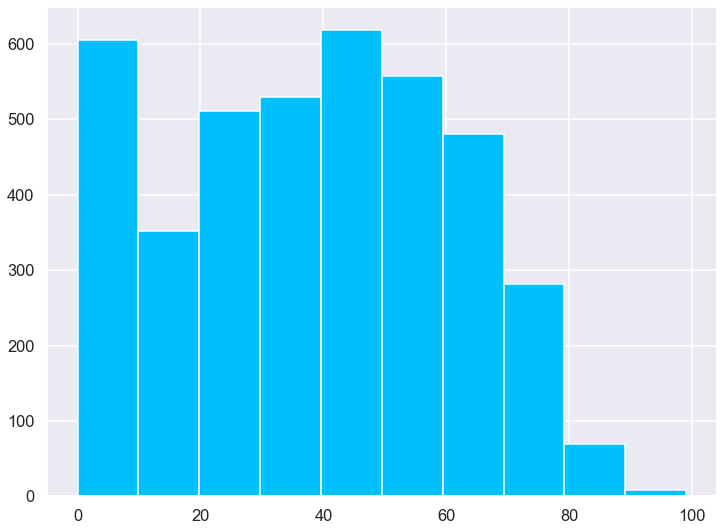

In [16]:
train.popularity.hist()

In [17]:
# manually bin popularity for use in visualization
bin_labels = ['Very Low', 'Low', 'Moderate', 'High']
#bin_labels = ['0 to 10', '11 to 40', '41 to 70', '71 to 100']
bins = [-1, 11, 41, 71, 101]
train['popularity_bins'] = pd.cut(x=train.popularity, labels=bin_labels, bins=bins, right=True)

pd.DataFrame(train['popularity_bins']).head(12)

,popularity_bins
track_id,
30bqVoKjX479ab90a8Pafp,High
0HO8pCseEpgozNi3z0R4bc,Low
643K3eEgRvdJiXjSzlz7dg,Low
08EabdvPIHC4KBW7LfynPP,Low
6B2ZDVgJ0lHLgV9xC2PAJh,Low
1YEwBpbhJ8KCNaQTGAL6mM,Moderate
3QHzPY9WWVcdJ7yQMWnFiy,Very Low
4fYVgBTMOShPGBKINMN45w,Moderate
3U1er6n2pSve0xcNVn9eUu,Moderate


# Does a track being explicit or not correlate with its popularity?

### Swarm plot

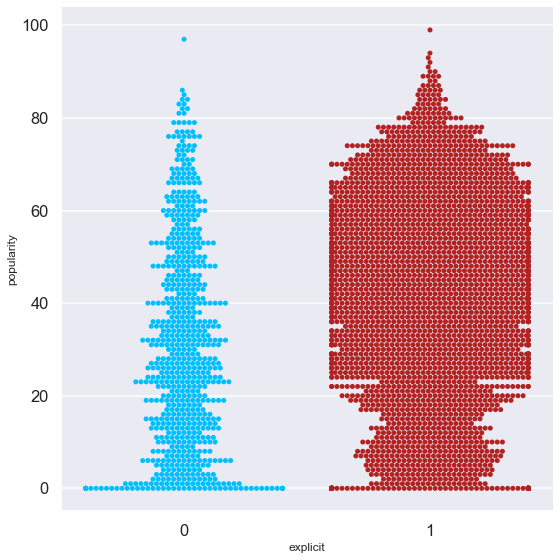

In [18]:
sns.catplot(x="explicit", y="popularity", kind="swarm", data=train, height=8, aspect=1)

### Independent T-Test

The features are independent because there is no overlap between observations in explicit and observations in not explicit.

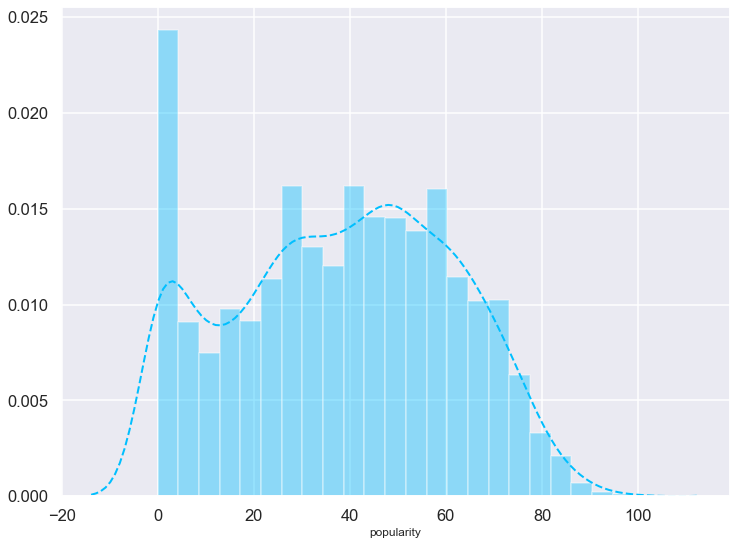

In [19]:
# check for normal distribution
sns.distplot(train.popularity)

In [20]:
train.explicit.value_counts()

1    3278
0     734
Name: explicit, dtype: int64

In [21]:
# compare variances
explicit_sample = train[train.explicit==True].popularity
not_explicit_sample = train[train.explicit==False].popularity

print(explicit_sample.var())
print(not_explicit_sample.var())

513.513123340272
504.3414302760856


No, so we will set the argument of equal_var to False.

**Set hypothesis and alpha:**

$H_{0}$: Mean of song popularity of explicit tracks = Mean of song popularity of non-explicit tracks

$H_{a}$: Mean of song popularity of explicit tracks > Mean of song popularity of non-explicit tracks

$\alpha$: .05

In [22]:
alpha = .05

**Compute test statistic and probability (t-statistic & p-value)**

In [23]:
t, p = stats.ttest_ind(explicit_sample, not_explicit_sample, equal_var = False)

print('Test statistic:', t, '\n', p/2, '\n', alpha)

Test statistic: 10.05099377722078 
 4.29048129445763e-23 
 0.05


**Decide**

In [24]:
null_hypothesis = "there is no significant difference between the mean popularity of explicit tracks and non-explicit tracks."

if p/2 < alpha:
    print("We reject the hypothesis that", null_hypothesis)
else:
    print("We fail to reject the null hypothesis.")

We reject the hypothesis that there is no significant difference between the mean popularity of explicit tracks and non-explicit tracks.


In [25]:
not_explicit_sample.mean(), explicit_sample.mean()

(30.78882833787466, 40.02135448444173)

Now put it in a function:

In [26]:
def explicit_viz(df):
    '''
    This function produces a swarm plot on explicit tracks' and non-explicit tracks' popularity.
    '''
    print('Does a track being explicit or not correlate with its popularity?')
    sns.catplot(x="explicit", y="popularity", kind="swarm", data=df)

In [27]:
def explicit_ttest(df, alpha):
    print('Set the alpha/significance level:')
    print('  alpha =', alpha)
    
    print('\n---\n')
    
    print('Check for normal distribution:')
    sns.distplot(df.popularity)
    plt.show()
    
    print('---\n')
    
    print('Check values counts:')
    print(df.explicit.value_counts())
    
    print('\n---\n')
    
    print('Compare variances:')
    explicit_sample = df[df.explicit==True].popularity
    not_explicit_sample = df[df.explicit==False].popularity
    
    # if [results of lavenes variance test], then equal_var = __ (automate checking similar variance)
    print(explicit_sample.var())
    print(not_explicit_sample.var())
          
    print("They are of similar variance, so we will set the argument of equal_var to True.")
    
    print('\n---\n')
          
    print("Compute test statistic and probability (t-statistic & p-value)")
    t, p = stats.ttest_ind(explicit_sample, not_explicit_sample, equal_var = True)
    print('Test statistic:', t, '\np-value:', p/2, '\nalpha:', alpha)
    
    print('\n---\n')
    
    null_hypothesis = "there is no significant difference between the mean popularity of explicit tracks and non-explicit tracks."
    if p/2 < alpha:
        print("We reject the hypothesis that", null_hypothesis)
    else:
        print("We fail to reject the null hypothesis.")
        
    print('\n---\n')
          
    print('mean of non-explicit songs:', not_explicit_sample.mean(), '\nmean of explicit songs:', explicit_sample.mean())

Set the alpha/significance level:
  alpha = 0.05

---

Check for normal distribution:


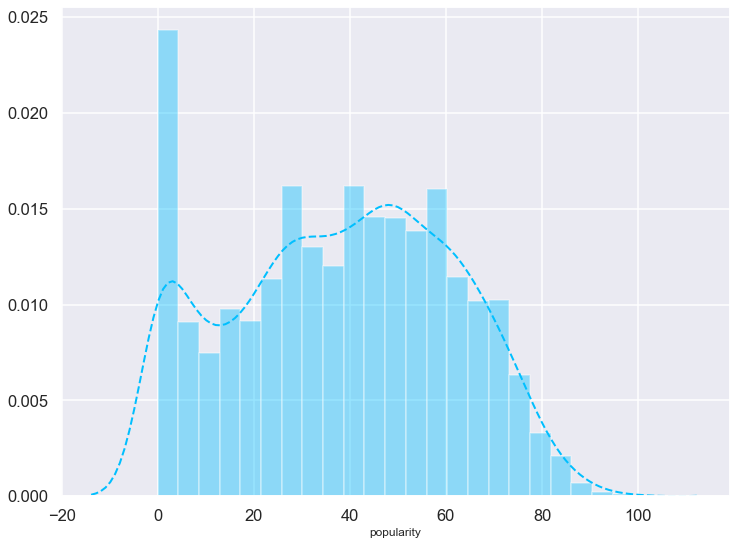

---

Check values counts:
1    3278
0     734
Name: explicit, dtype: int64

---

Compare variances:
513.513123340272
504.3414302760856
They are of similar variance, so we will set the argument of equal_var to True.

---

Compute test statistic and probability (t-statistic & p-value)
Test statistic: 9.99371405241702 
p-value: 1.515294887659819e-23 
alpha: 0.05

---

We reject the hypothesis that there is no significant difference between the mean popularity of explicit tracks and non-explicit tracks.

---

mean of non-explicit songs: 30.78882833787466 
mean of explicit songs: 40.02135448444173


In [28]:
explicit_ttest(train, alpha)

# Does loudness have a relationship with popularity?

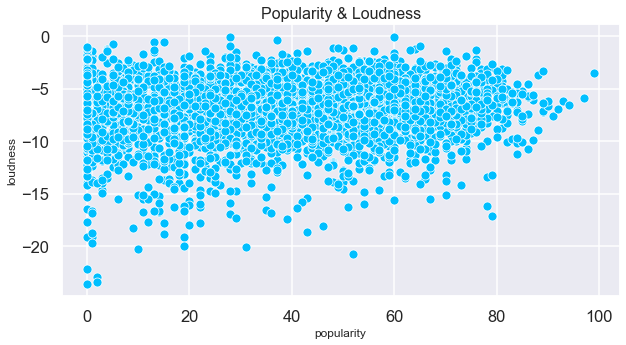

In [29]:
plt.figure(figsize=(10,5))
plt.title('Popularity & Loudness')
plt.ylabel('Loudness')
plt.xlabel('Popularity')
sns.scatterplot(train['popularity'], train['loudness'])
plt.show()

Doesn't appear to be any valuable insights here.

# Are originals or remixes more popular?

In [30]:
train[train.track_name.str.contains('remix', case=True, flags=0, regex=False)]

,release_year,release_month,release_day,artist,album,release_date,track_name,album_popularity,label,danceability,...,wrestling,wu fam,zambian hip hop,zouk riddim,duration_seconds,duration_minutes,is_featured_artist,decade,is_top_billboard_label,popularity_bins
track_id,,,,,,,,,,,,,,,,,,,,,
1IlJZCRthVEPlksVzj3JWY,2020,10,16,sada baby,whole lotta choppas (remix) [feat. nicki minaj],2020-10-16,whole lotta choppas (remix) [feat. nicki minaj],65,Asylum Worldwide LLC,0.956,...,0,0,0,0,173,2,1,2020s,0,High
6s8EhlBn2PIoESylkXnwYc,2019,11,29,kamelen,kingpin slim,2019-11-29,kingpin o.g - remix,46,NMG/G-HUSET,0.649,...,0,0,0,0,254,4,0,2010s,0,Low
11YP90W36r34d2qrjAcPq4,2018,10,19,queen key,my way (remix),2018-10-19,my way (remix),29,Machine Entertainment Group,0.849,...,0,0,0,0,207,3,0,2010s,0,Low
3gTpy8lhCIyNWSVQxEpdBi,2004,05,14,"juvenile, skip, wacko",the beginning of the end...,2004-05-14,nolia clap - remix,0,Rap-A-Lot Fontana,0.789,...,0,0,0,0,270,4,0,2000s,0,Very Low
60eZwR3BMCP2yVkUBsD69O,2020,06,19,lil loaded,6locc 6a6y (feat. nle choppa) [remix],2020-06-19,6locc 6a6y (feat. nle choppa) - remix,58,Lil Loaded Music,0.862,...,0,0,0,0,176,2,1,2020s,0,Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6MO2bfLHKykUgCChFdw91H,2020,01,17,h.e.r.,"slide (remix) (feat. pop smoke, a boogie wit d...",2020-01-17,"slide (remix) (feat. pop smoke, a boogie wit d...",70,MBK Entertainment/RCA Records,0.815,...,0,0,0,0,296,4,1,2020s,0,High
0XkmeG97T4mtYlWRJcrxec,2020,07,10,staysolidrocky,party girl (remix),2020-07-10,party girl (remix),63,Columbia,0.752,...,0,0,0,0,147,2,0,2020s,1,Moderate
35KcXRWo7BTYdJiyMOy2Zu,1998,05,26,various artists,can't hardly wait,1998-05-26,swing my way - remix,50,Elektra Records,0.769,...,0,0,0,0,248,4,0,90s,0,Low


In [31]:
train[train.track_name.str.contains('Nolia', case=True, flags=0, regex=False)]

,release_year,release_month,release_day,artist,album,release_date,track_name,album_popularity,label,danceability,...,wrestling,wu fam,zambian hip hop,zouk riddim,duration_seconds,duration_minutes,is_featured_artist,decade,is_top_billboard_label,popularity_bins
track_id,,,,,,,,,,,,,,,,,,,,,


In [32]:
train.columns

Index(['release_year', 'release_month', 'release_day', 'artist', 'album',
       'release_date', 'track_name', 'album_popularity', 'label',
       'danceability',
       ...
       'wrestling', 'wu fam', 'zambian hip hop', 'zouk riddim',
       'duration_seconds', 'duration_minutes', 'is_featured_artist', 'decade',
       'is_top_billboard_label', 'popularity_bins'],
      dtype='object', length=418)

There are not enough remixes and originals to compare.

# What are the drivers of popularity?

In [33]:
def corr_heatmap(train):
    '''
    This function creates a heatmap of the correlation of all features scaled, minus longitude and latitude and redundant features.
    Takes a dataFrame as an argument
    '''
    # heatmap time!
    heatmap_data = train
    corr = heatmap_data.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    ax = sns.heatmap(corr, mask=mask, center=0, vmin=0, vmax=1, cmap=sns.diverging_palette(95, 220, n=250, s=93, l=35), square=True) 
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, horizontalalignment='right')
    plt.title('Which features have significant correlation?')
    ax

In [34]:
#corr_heatmap(train.drop(columns=['artist', 'album', 'track_name', 'release_date']))

Looks like the top drivers of popularity across all of the tracks are danceability, instrumentalness, and explicit.

# Do instrumentals/lyrics have an effect on popularity?

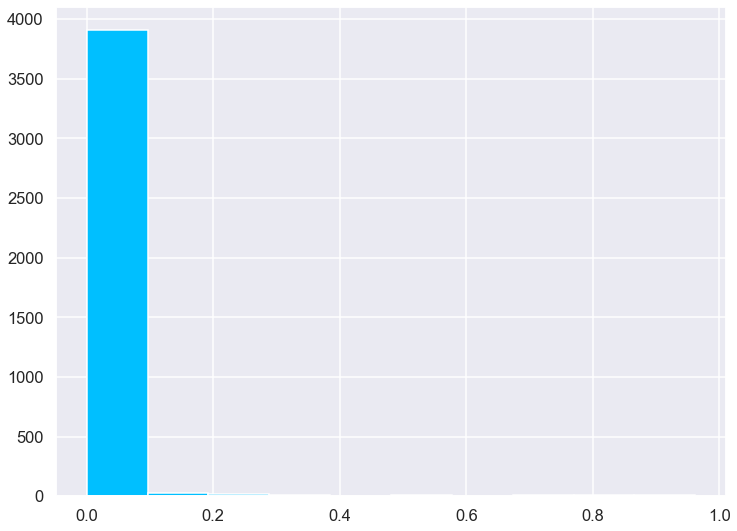

In [35]:
train.instrumentalness.hist()

In [36]:
train.instrumentalness.value_counts()

0.000000    2443
0.000001       6
0.000029       5
0.000015       5
0.000001       5
            ... 
0.012800       1
0.000506       1
0.011000       1
0.000189       1
0.000065       1
Name: instrumentalness, Length: 1245, dtype: int64

In [37]:
train.instrumentalness.max()

0.962

In [38]:
train['instrumentalness_boolean'] = train["instrumentalness"] > 0.0
train.head()

,release_year,release_month,release_day,artist,album,release_date,track_name,album_popularity,label,danceability,...,wu fam,zambian hip hop,zouk riddim,duration_seconds,duration_minutes,is_featured_artist,decade,is_top_billboard_label,popularity_bins,instrumentalness_boolean
track_id,,,,,,,,,,,,,,,,,,,,,
30bqVoKjX479ab90a8Pafp,2019,04,19,lil peep,star shopping,2019-04-19,star shopping,80,Lil Peep,0.585,...,0,0,0,142,2,0,2010s,0,High,True
0HO8pCseEpgozNi3z0R4bc,2015,03,17,father,who's gonna get fucked first?,2015-03-17,everybody in the club gettin shot,26,Awful Records,0.833,...,0,0,0,120,2,0,2010s,0,Low,False
643K3eEgRvdJiXjSzlz7dg,1998,08,11,m.o.p.,first family 4 life,1998-08-11,breakin' the rules,36,Relativity Records,0.471,...,0,0,0,252,4,0,90s,0,Low,False
08EabdvPIHC4KBW7LfynPP,1993,10,12,salt-n-pepa,very necessary,1993-10-12,no one does it better,64,Mercury Records,0.874,...,0,0,0,234,3,0,90s,0,Low,False
6B2ZDVgJ0lHLgV9xC2PAJh,2001,10,22,dungeon family,even in darkness,2001-10-22,white gutz (feat. bubba sparxxx),42,Arista,0.857,...,0,0,0,266,4,1,2000s,0,Low,True


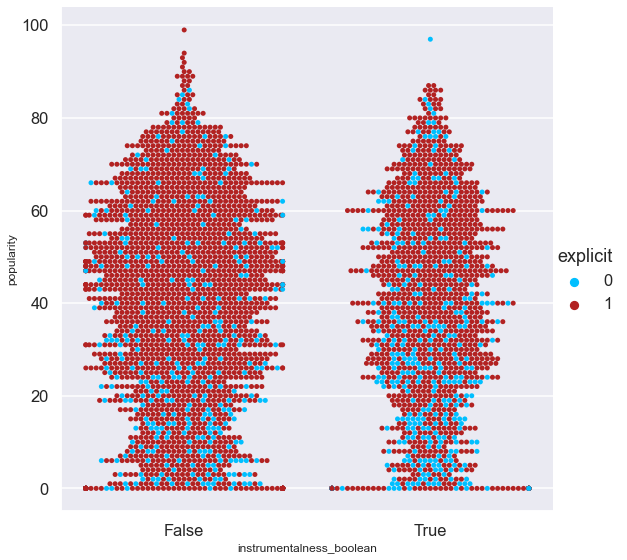

In [39]:
sns.catplot(x="instrumentalness_boolean", y="popularity", hue="explicit", kind="swarm", data=train, height=8, aspect=1)

There doesn't appear to be a significant difference in popularity between songs with a 0.0 amount of instrumentalness, and songs that have over 0.0 amount of instrumentalness.

# Further feature engineering and exploration

In [40]:
train.head()

,release_year,release_month,release_day,artist,album,release_date,track_name,album_popularity,label,danceability,...,wu fam,zambian hip hop,zouk riddim,duration_seconds,duration_minutes,is_featured_artist,decade,is_top_billboard_label,popularity_bins,instrumentalness_boolean
track_id,,,,,,,,,,,,,,,,,,,,,
30bqVoKjX479ab90a8Pafp,2019,04,19,lil peep,star shopping,2019-04-19,star shopping,80,Lil Peep,0.585,...,0,0,0,142,2,0,2010s,0,High,True
0HO8pCseEpgozNi3z0R4bc,2015,03,17,father,who's gonna get fucked first?,2015-03-17,everybody in the club gettin shot,26,Awful Records,0.833,...,0,0,0,120,2,0,2010s,0,Low,False
643K3eEgRvdJiXjSzlz7dg,1998,08,11,m.o.p.,first family 4 life,1998-08-11,breakin' the rules,36,Relativity Records,0.471,...,0,0,0,252,4,0,90s,0,Low,False
08EabdvPIHC4KBW7LfynPP,1993,10,12,salt-n-pepa,very necessary,1993-10-12,no one does it better,64,Mercury Records,0.874,...,0,0,0,234,3,0,90s,0,Low,False
6B2ZDVgJ0lHLgV9xC2PAJh,2001,10,22,dungeon family,even in darkness,2001-10-22,white gutz (feat. bubba sparxxx),42,Arista,0.857,...,0,0,0,266,4,1,2000s,0,Low,True


Below are the top ten record labels with the highest average of song popularity across the 6000~ trasks we have in the dataset right now. Of course, some of these labels may have a small number of observations in them. Matt has done further exploration with the labels in his notebook.

In [41]:
pd.DataFrame(train.groupby('label')['popularity'].mean().sort_values(ascending=False).head(10))

,popularity
label,
CJ Music Group,91.0
Chris Brown Entertainment/300 Entertainment/RCA Records,88.0
Cactus Jack / Epic / Grand Hustle,88.0
Arizona Zervas,87.0
Victor Victor Worldwide/Republic Records,86.0
OVO/We The Best/Epic,86.0
Internet Money Records/ TenThousand Projects,84.0
Victor Victor Worldwide,83.0
Roc Nation W Smith P&D,83.0


Will eventually need to use regex to seperate out each the labels (delimited by a ```/```).

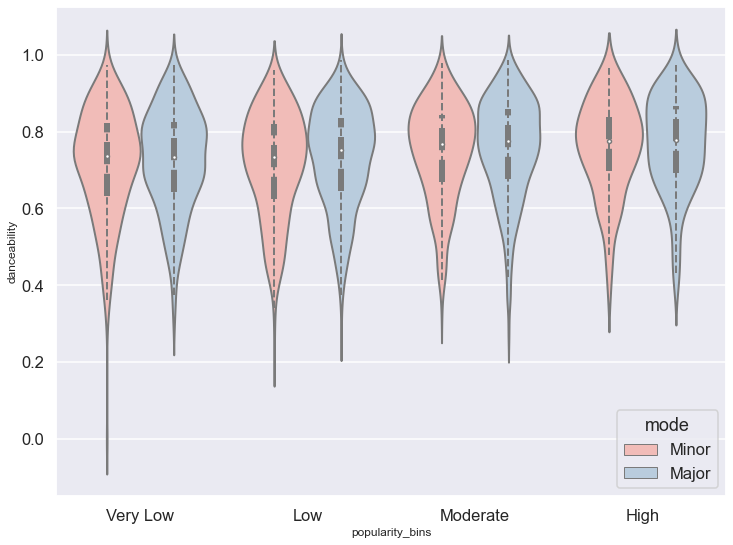

In [42]:
# Grouped violinplot
sns.violinplot(x='popularity_bins', y="danceability", hue="mode", data=train, palette="Pastel1")
plt.show()

Text(0.5, 1.0, 'How many minutes long are songs that are popular, grouped by songs with featured artists and without?')

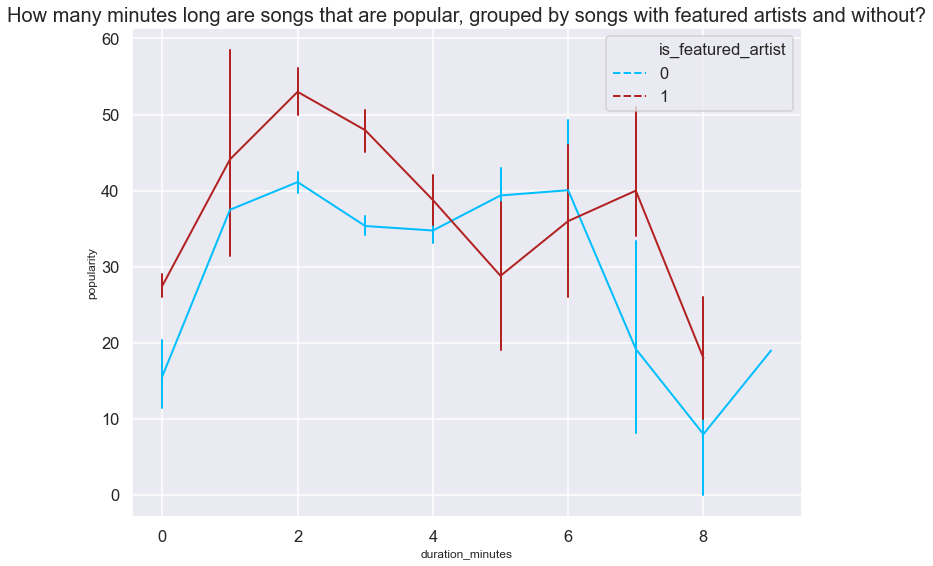

In [43]:
sns.lineplot(data=train, x="duration_minutes", y="popularity", hue="is_featured_artist", err_style="bars")
plt.title(label="How many minutes long are songs that are popular, grouped by songs with featured artists and without?", size=20)

Takeaways: 

## Creating is_top_billboard_label

Def Jam, Young Money, Roc-A-Fella, Jive, Bad Boy, Grand Hustle, Shady, Ruffhouse, Cash Money, Columbia

Reference: https://pudding.cool/2017/03/labels/

In [44]:
top_ten_billboard = ['Def Jam', 'Young Money', 'Roc-A-Fella', 'Jive', 'Bad Boy', 'Grand Hustle', 'Shady', 'Ruffhouse', 'Cash Money', 'Columbia']
print(top_ten_billboard)
print()

pattern = '|'.join(top_ten_billboard)

train['is_top_billboard_label'] = train.label.str.contains(pattern)

train['is_top_billboard_label'] = train.is_top_billboard_label.astype('int')

print(train.is_top_billboard_label.value_counts())

['Def Jam', 'Young Money', 'Roc-A-Fella', 'Jive', 'Bad Boy', 'Grand Hustle', 'Shady', 'Ruffhouse', 'Cash Money', 'Columbia']

0    3531
1     481
Name: is_top_billboard_label, dtype: int64


Text(0.5, 1.0, 'Avg popularity of tracks produced by top ten hip hop labels (per Billboard performance) vs total avg')

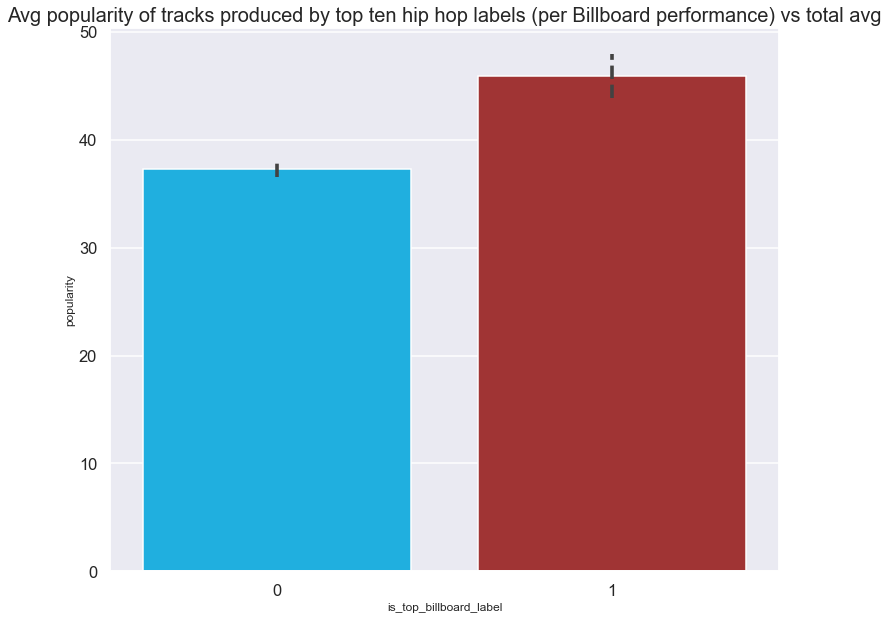

In [45]:
plt.figure(figsize=(12,10))
sns.barplot(x=train.is_top_billboard_label, y=train.popularity)
plt.title('Avg popularity of tracks produced by top ten hip hop labels (per Billboard performance) vs total avg', fontsize=20)

# Looking at musical profiles:

In [46]:
train.popularity_bins.value_counts()

Moderate    1614
Low         1441
Very Low     678
High         279
Name: popularity_bins, dtype: int64

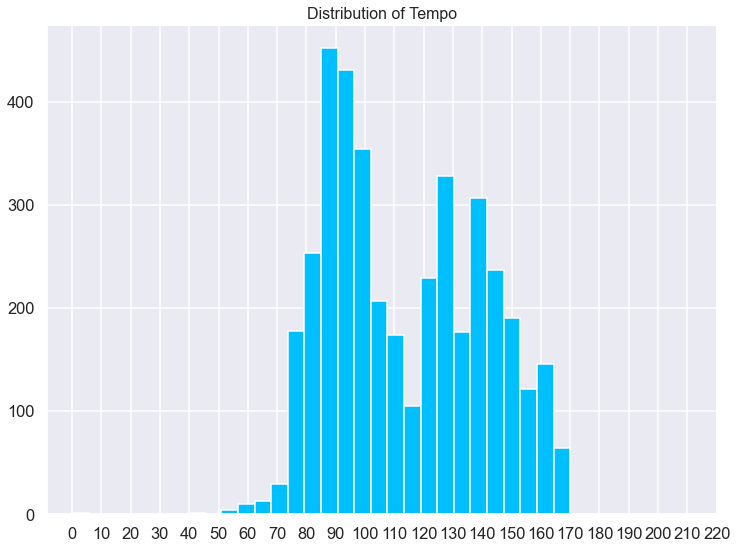

In [47]:
train.tempo.hist(bins=30)
x_ticks = np.arange(0, 230, 10)
plt.xticks(x_ticks)
plt.title("Distribution of Tempo")
plt.show()

In [48]:
# manually bin tempo with domain knowledge for use in visualization
bin_labels = ['90 and under', '91 to 110', '111 to 130', '131 to 150', '151 to 170']
#bins = pd.IntervalIndex.from_tuples([(0, 90), (2, 3), (4, 5)])
bins = [0, 91, 111, 131, 151, 171]
#train['tempo_bins'] = pd.qcut(train['tempo'], q=5, precision=0, labels=bin_labels)
train['tempo_bins'] = pd.cut(x=train.tempo, labels=bin_labels, bins=bins, right=True)

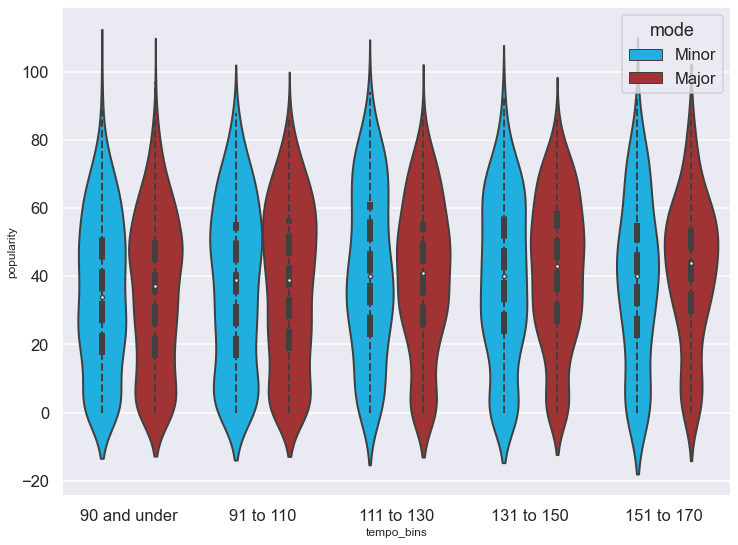

In [49]:
ax = sns.violinplot(x="tempo_bins", y="popularity", hue="mode",data=train)

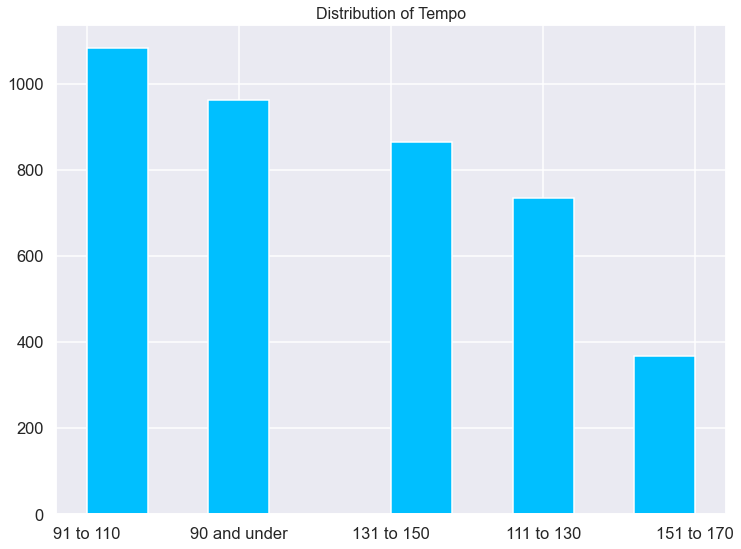

In [50]:
train.tempo_bins.hist()
#x_ticks = np.arange(0, 230, 10)
#plt.xticks(x_ticks)
plt.title("Distribution of Tempo")
plt.show()

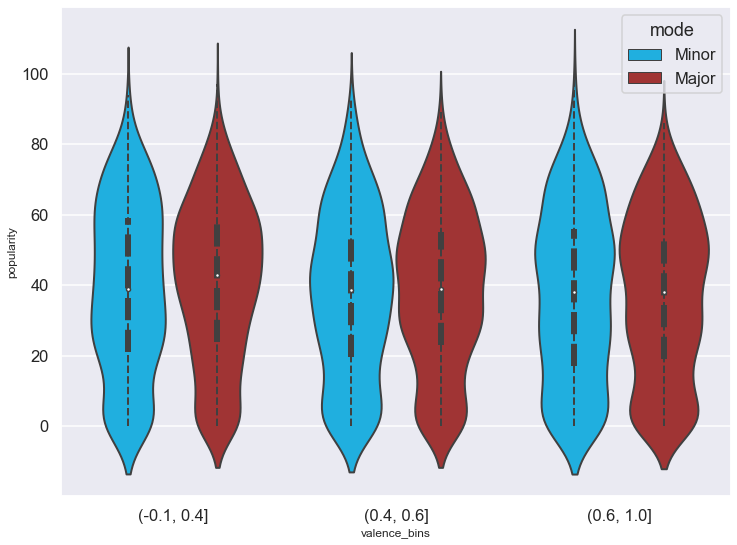

In [51]:
train['valence_bins'] = pd.qcut(train['valence'], q=3, precision=0)
ax = sns.violinplot(x="valence_bins", y="popularity", hue="mode",data=train)

In [52]:
train.columns

Index(['release_year', 'release_month', 'release_day', 'artist', 'album',
       'release_date', 'track_name', 'album_popularity', 'label',
       'danceability',
       ...
       'zouk riddim', 'duration_seconds', 'duration_minutes',
       'is_featured_artist', 'decade', 'is_top_billboard_label',
       'popularity_bins', 'instrumentalness_boolean', 'tempo_bins',
       'valence_bins'],
      dtype='object', length=421)

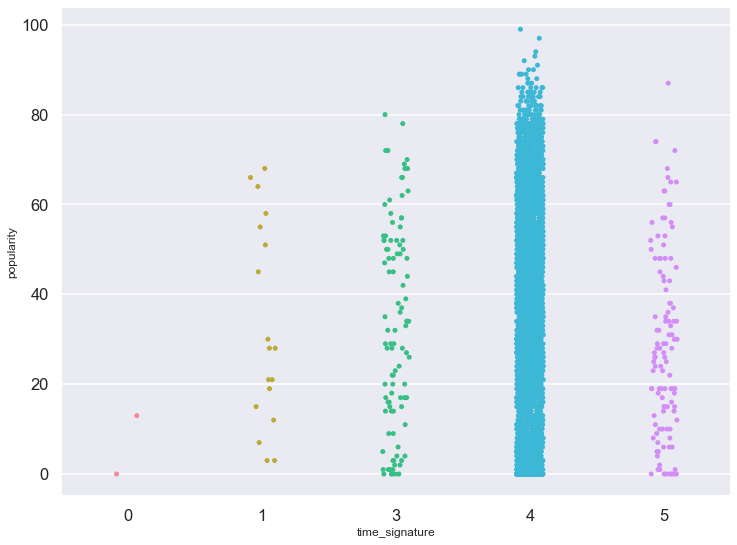

In [53]:
ax = sns.stripplot(x="time_signature", y="popularity", data=train)

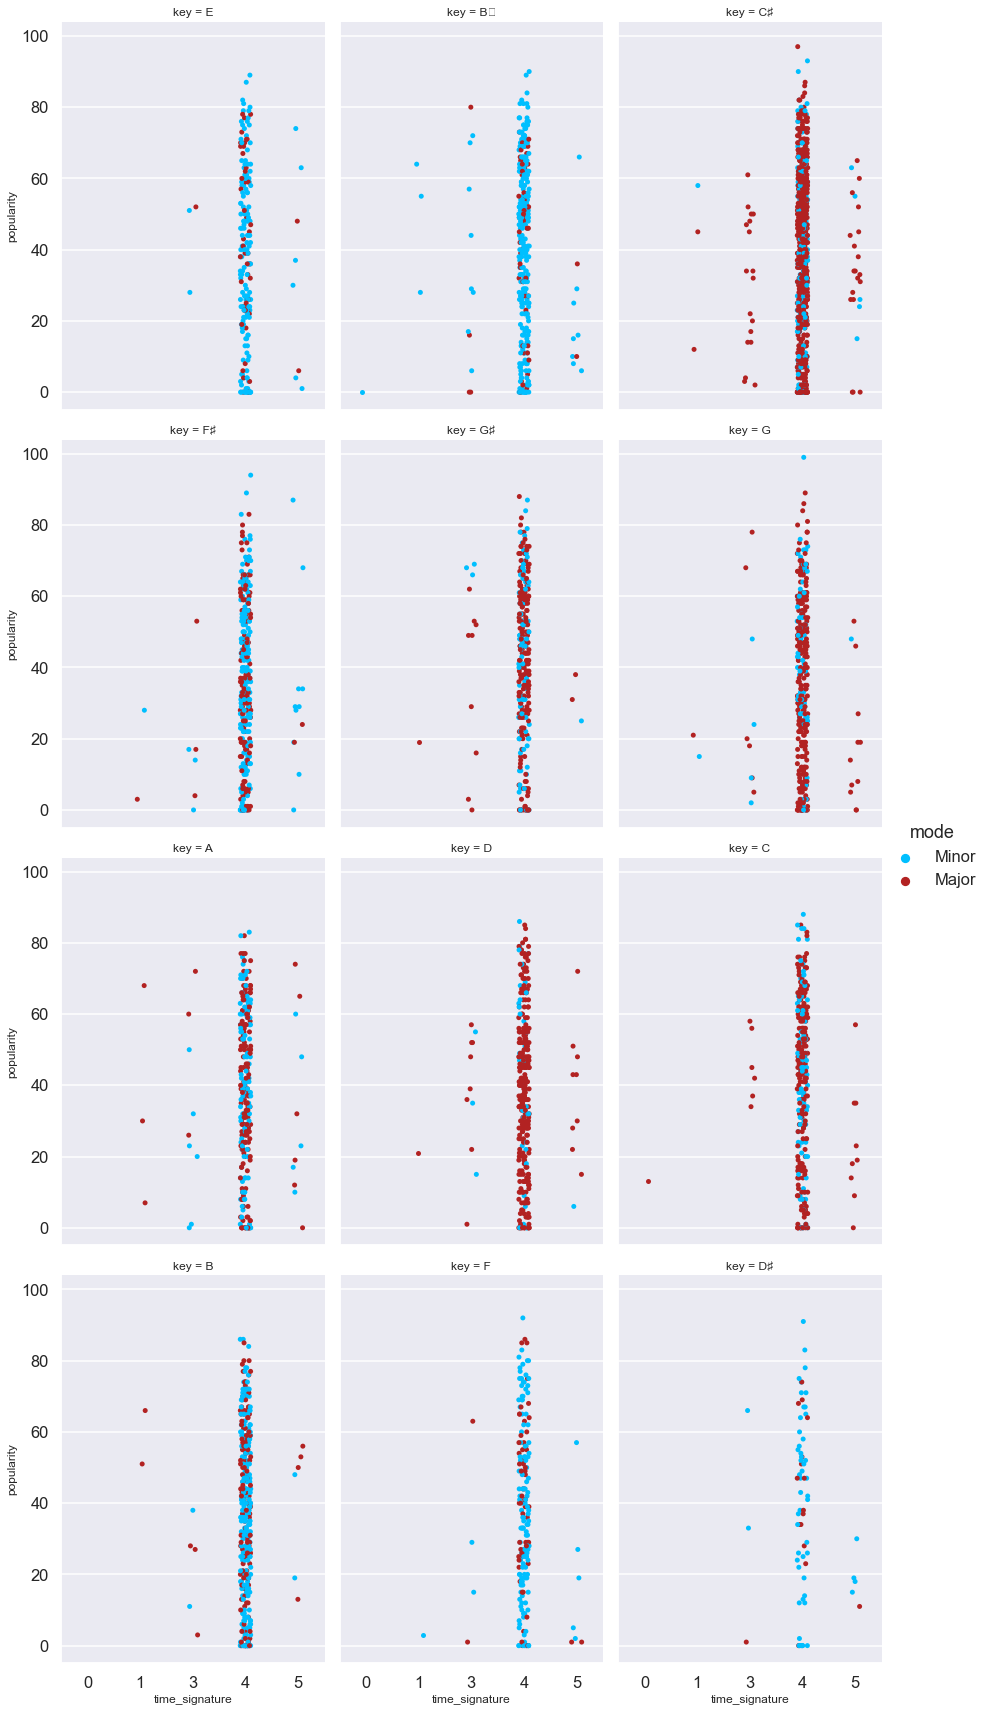

In [54]:
g = sns.catplot(x="time_signature", y="popularity",
                hue="mode", col="key",
                data=train, kind="strip",
                height=6, aspect=.7, col_wrap=3);

In [55]:
#train.groupby(['danceability', 'mode'])['popularity'].mean().unstack().plot()

In [56]:
train['danceability_bins'] = pd.qcut(train['danceability'], q=4, precision=0)

In [57]:
train.columns

Index(['release_year', 'release_month', 'release_day', 'artist', 'album',
       'release_date', 'track_name', 'album_popularity', 'label',
       'danceability',
       ...
       'duration_seconds', 'duration_minutes', 'is_featured_artist', 'decade',
       'is_top_billboard_label', 'popularity_bins', 'instrumentalness_boolean',
       'tempo_bins', 'valence_bins', 'danceability_bins'],
      dtype='object', length=422)

In [58]:
# to explore in databricks and then come back here with the ones i like
audio = train[['popularity', 'is_featured_artist', 'explicit', 'popularity_bins',
              'is_top_billboard_label', 'danceability', 'energy', 'key', 'mode',
              'speechiness', 'valence', 'tempo', 'time_signature', 'duration_minutes',
              'album_type', 'tempo_bins', 'danceability_bins', 'valence_bins']]

In [59]:
audio.to_csv('audio_features.csv')

In [60]:
train.columns

Index(['release_year', 'release_month', 'release_day', 'artist', 'album',
       'release_date', 'track_name', 'album_popularity', 'label',
       'danceability',
       ...
       'duration_seconds', 'duration_minutes', 'is_featured_artist', 'decade',
       'is_top_billboard_label', 'popularity_bins', 'instrumentalness_boolean',
       'tempo_bins', 'valence_bins', 'danceability_bins'],
      dtype='object', length=422)

In [61]:
train.time_signature.value_counts()

4    3776
5     117
3      99
1      18
0       2
Name: time_signature, dtype: int64

In [62]:
# relabel time_signature values and rename column for vizualization purposes

time_sigs = train
time_sigs['time_signature'] = time_sigs.time_signature.map({0: 'Complex or Changing', 1: 'Complex or Changing', 3: '3/4', 4: '4/4', 5: '5/4'})
time_sigs = time_sigs.rename(columns={"time_signature": "Time Signature",})

pd.DataFrame(time_sigs['Time Signature'])

,Time Signature
track_id,
30bqVoKjX479ab90a8Pafp,4/4
0HO8pCseEpgozNi3z0R4bc,4/4
643K3eEgRvdJiXjSzlz7dg,4/4
08EabdvPIHC4KBW7LfynPP,4/4
6B2ZDVgJ0lHLgV9xC2PAJh,4/4
...,...
6Hf3lTdh7gNQO3GoVw9CEM,4/4
1HnYtO4YEAMf98bu3hiYNA,5/4
0IShCbw4JJEpcmZiTwAena,4/4


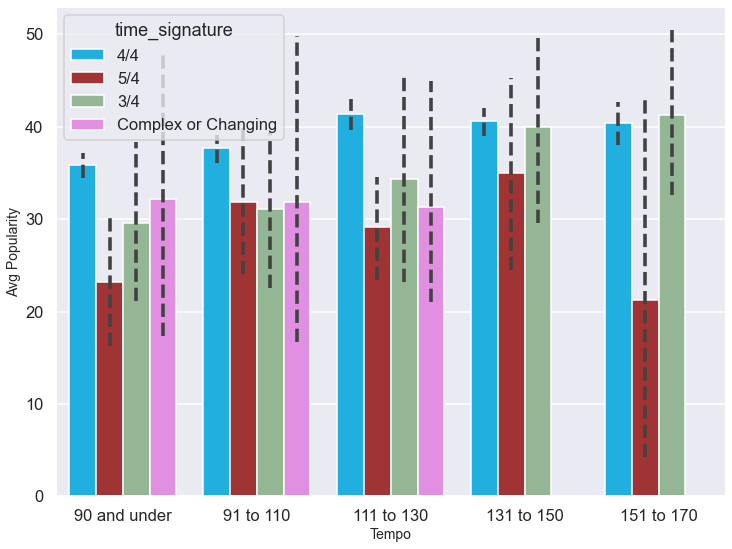

In [63]:
sns.barplot(x="tempo_bins", y="popularity", hue="time_signature", data=train.drop(train[train.time_signature == 0].index))
plt.xlabel("Tempo", size=14)
plt.ylabel("Avg Popularity", size=14)
plt.show()

In [64]:
train[train['time_signature'] == 1]

,release_year,release_month,release_day,artist,album,release_date,track_name,album_popularity,label,danceability,...,duration_seconds,duration_minutes,is_featured_artist,decade,is_top_billboard_label,popularity_bins,instrumentalness_boolean,tempo_bins,valence_bins,danceability_bins
track_id,,,,,,,,,,,,,,,,,,,,,


# Explore Genre

In [65]:
genre = pd.read_csv('genre_count_df.csv', index_col=0)
genre.head()

,artist,album,release_date,track_name,album_popularity,label,danceability,energy,key,loudness,...,west coast rap,west coast trap,winnipeg hip hop,witch house,wonky,worship,wrestling,wu fam,zambian hip hop,zouk riddim
track_id,,,,,,,,,,,,,,,,,,,,,
6mecZbKK3JDeMdFRNxsCV5,tay-k,trapman,2020-07-12,trapman,36,Tay-K,0.792,0.594,2,-8.544,...,0,0,0,0,0,0,0,0,0,0
5PtMwNq8Dp31uYdGGacVJE,lil wyte,doubt me now,2003-03-04,oxy cotton,55,Hypnotize Minds Productions,0.816,0.578,9,-6.912,...,0,0,0,0,0,0,0,0,0,0
6s8EhlBn2PIoESylkXnwYc,kamelen,kingpin slim,2019-11-29,kingpin o.g - remix,46,NMG/G-HUSET,0.649,0.798,0,-6.450,...,0,0,0,0,0,0,0,0,0,0
2e9EZ2V5QGGZPMJacO3y0Y,waka flocka flame,flockaveli,2010-10-01,grove st. party (feat. kebo gotti),71,Asylum/Warner Records,0.705,0.702,0,-4.783,...,0,0,0,0,0,0,0,0,0,0
3ZRd5Z0fiYtASLdEPPb16m,project pat,mista don't play: everythangs workin',2001-02-13,don't save her (feat. crunchy black),55,Hypnotize Minds Productions,0.838,0.793,11,-5.470,...,0,0,0,0,0,0,0,0,0,0


In [66]:
genre.T

track_id,6mecZbKK3JDeMdFRNxsCV5,5PtMwNq8Dp31uYdGGacVJE,6s8EhlBn2PIoESylkXnwYc,2e9EZ2V5QGGZPMJacO3y0Y,3ZRd5Z0fiYtASLdEPPb16m,3XQY8kDjI8LARMIC9xkxQk,4k5xJOxoJbMW5sdkZGOezj,0RGEQZt56cK8cxr2QdG4Ih,6rUcS9i07F6okIe8wujs5J,59rtiYOPgMEDf3yPEfU2la,...,621nU4L9xr7yH5JhATeY1P,2KU5iwjXpjnb5URdkAWhhj,6c6FT2QJDKLWVCOaVF6fCz,5mAERlwGIlGyuROXeT3VPI,0rDqLVWxe9ngG48EWM4Whq,5G9IXRzPaRJssJE76TDenY,0g3zIOFTdkwgJdR48usYgY,75Z53FMCvlupjHfAh9XgDo,7pXg4n5cOsZvMPsEtemNgz,2gVtrY8gCCynR9v0lyBL1m
artist,tay-k,lil wyte,kamelen,waka flocka flame,project pat,waka flocka flame,project pat,lil jon & the east side boyz,gucci mane,mike jones,...,blaatina,nia kay,hood brat,kamillion,dounia,tkay maidza,beyoncé,shenseea,sally sossa,tank and the bangas
album,trapman,doubt me now,kingpin slim,flockaveli,mista don't play: everythangs workin',flockaveli,mista don't play: everythangs workin',crunkest hits,the state vs. radric davis (deluxe),who is mike jones?,...,oouwee,brand new,please,here we go,bitch give me your heart,shook,the lion king: the gift [deluxe edition],the sidechick song,100 flows,self care
release_date,2020-07-12,2003-03-04,2019-11-29,2010-10-01,2001-02-13,2010-10-01,2001-02-13,2011-03-15,2009-12-04,2005-04-19,...,2019-03-01,2020-04-11,2019-12-16,2019-12-13,2020-05-21,2020-05-12,2020-07-31,2020-03-09,2020-10-20,2020-10-07
track_name,trapman,oxy cotton,kingpin o.g - remix,grove st. party (feat. kebo gotti),don't save her (feat. crunchy black),hard in da paint,chickenhead (feat. la chat & three 6 mafia),throw it up,lemonade,still tippin' (feat. slim thug and paul wall),...,oouwee,brand new,please,here we go,bitch give me your heart,shook,my power,the sidechick song,100 flows,self care
album_popularity,36,55,46,71,55,71,55,61,58,61,...,18,10,11,20,22,26,73,45,41,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
worship,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wrestling,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
wu fam,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
zambian hip hop,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
list(genre.columns)

['artist',
 'album',
 'release_date',
 'track_name',
 'album_popularity',
 'label',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms',
 'time_signature',
 'explicit',
 'popularity',
 'disc_number',
 'track_number',
 'album_id',
 'album_type',
 'duration_seconds',
 'duration_minutes',
 'is_featured_artist',
 'release_year',
 'release_month',
 'release_day',
 'artist_genres',
 'abstract hip hop',
 'acid jazz',
 'acoustic chill',
 'afro dancehall',
 'afrofuturism',
 'afrofuturismo brasileiro',
 'afropop',
 'afroswing',
 'alabama rap',
 'alberta hip hop',
 'alternative dance',
 'alternative hip hop',
 'alternative metal',
 'alternative r&b',
 'alternative rock',
 'argentine hip hop',
 'arkansas hip hop',
 'art pop',
 'asian american hip hop',
 'atl hip hop',
 'atl trap',
 'aussie drill',
 'austin hip hop',
 'australian dance',
 'australian electropop',
 'australian hip hop',
 'australian pop',
 '

In [68]:
genre

,artist,album,release_date,track_name,album_popularity,label,danceability,energy,key,loudness,...,west coast rap,west coast trap,winnipeg hip hop,witch house,wonky,worship,wrestling,wu fam,zambian hip hop,zouk riddim
track_id,,,,,,,,,,,,,,,,,,,,,
6mecZbKK3JDeMdFRNxsCV5,tay-k,trapman,2020-07-12,trapman,36,Tay-K,0.792,0.594,2,-8.544,...,0,0,0,0,0,0,0,0,0,0
5PtMwNq8Dp31uYdGGacVJE,lil wyte,doubt me now,2003-03-04,oxy cotton,55,Hypnotize Minds Productions,0.816,0.578,9,-6.912,...,0,0,0,0,0,0,0,0,0,0
6s8EhlBn2PIoESylkXnwYc,kamelen,kingpin slim,2019-11-29,kingpin o.g - remix,46,NMG/G-HUSET,0.649,0.798,0,-6.450,...,0,0,0,0,0,0,0,0,0,0
2e9EZ2V5QGGZPMJacO3y0Y,waka flocka flame,flockaveli,2010-10-01,grove st. party (feat. kebo gotti),71,Asylum/Warner Records,0.705,0.702,0,-4.783,...,0,0,0,0,0,0,0,0,0,0
3ZRd5Z0fiYtASLdEPPb16m,project pat,mista don't play: everythangs workin',2001-02-13,don't save her (feat. crunchy black),55,Hypnotize Minds Productions,0.838,0.793,11,-5.470,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5G9IXRzPaRJssJE76TDenY,tkay maidza,shook,2020-05-12,shook,26,4AD,0.895,0.791,4,-4.581,...,0,0,0,0,0,0,0,0,0,0
0g3zIOFTdkwgJdR48usYgY,beyoncé,the lion king: the gift [deluxe edition],2020-07-31,my power,73,Parkwood Entertainment/Columbia,0.769,0.856,7,-4.923,...,0,0,0,0,0,0,0,0,0,0
75Z53FMCvlupjHfAh9XgDo,shenseea,the sidechick song,2020-03-09,the sidechick song,45,Attomatic Records - Romeich Major,0.736,0.615,8,-4.716,...,0,0,0,0,0,0,0,0,0,0


### How many tracks of each genre?

In [69]:
for col in genre.iloc[ :, 31:417]:
    print(col + ': ', genre[col].sum())

abstract hip hop:  2
acid jazz:  1
acoustic chill:  1
afro dancehall:  1
afrofuturism:  16
afrofuturismo brasileiro:  14
afropop:  1
afroswing:  35
alabama rap:  17
alberta hip hop:  3
alternative dance:  2
alternative hip hop:  168
alternative metal:  3
alternative r&b:  171
alternative rock:  6
argentine hip hop:  1
arkansas hip hop:  37
art pop:  13
asian american hip hop:  2
atl hip hop:  422
atl trap:  36
aussie drill:  1
austin hip hop:  1
australian dance:  2
australian electropop:  1
australian hip hop:  22
australian pop:  1
australian trap:  2
australian underground hip hop:  1
baltimore hip hop:  5
bass music:  2
bass trap:  2
basshall:  1
baton rouge rap:  24
battle rap:  18
bay area indie:  1
bboy:  2
bc underground hip hop:  8
beats:  1
bedroom pop:  3
bedroom soul:  3
belgian dance:  1
belgian edm:  1
belgian hip hop:  7
big beat:  1
big room:  5
birmingham hip hop:  29
bmore:  65
boom bap:  21
boston hip hop:  11
bounce:  10
boy band:  3
british indie rock:  1
british s

In [70]:
# now I'll put it in pd df format.

genre_counts = pd.DataFrame([])
values = []
columns = []

for col in genre.iloc[ :, 31:417]:
    columns.append(col)

for col in genre.iloc[ :, 31:417]:
    values.append(genre[col].sum())

In [71]:
new_values = pd.Series(values, index=columns)
genre_counts = genre_counts.append(new_values, ignore_index=True)

genre_counts.head()

,abstract hip hop,acid jazz,acoustic chill,afro dancehall,afrofuturism,afrofuturismo brasileiro,afropop,afroswing,alabama rap,alberta hip hop,...,west coast rap,west coast trap,winnipeg hip hop,witch house,wonky,worship,wrestling,wu fam,zambian hip hop,zouk riddim
0,2.0,1.0,1.0,1.0,16.0,14.0,1.0,35.0,17.0,3.0,...,119.0,33.0,1.0,1.0,4.0,1.0,9.0,5.0,2.0,2.0


In [72]:
genre_counts.T.to_csv('genre_sums_df.csv')

In [73]:
genre_counts = genre_counts.T
genre_counts = genre_counts.rename(columns={0: "counts"})

genre_counts.head()

,counts
abstract hip hop,2.0
acid jazz,1.0
acoustic chill,1.0
afro dancehall,1.0
afrofuturism,16.0


In [74]:
genre_counts.shape

(386, 1)

There are 386 genres.

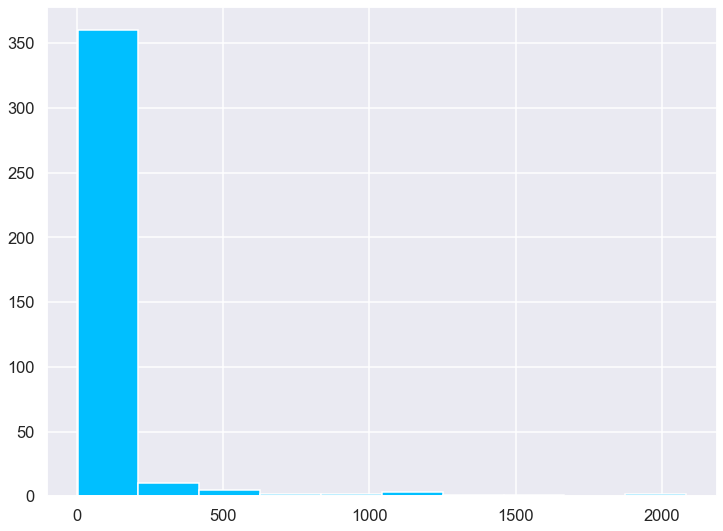

In [75]:
genre_counts.counts.hist()

In [76]:
genre_counts.tail(12).sort_values(by="counts")

,counts
winnipeg hip hop,1.0
witch house,1.0
worship,1.0
wave,2.0
zambian hip hop,2.0
zouk riddim,2.0
vogue,4.0
wonky,4.0
wu fam,5.0
wrestling,9.0


In [77]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

genre_counts[genre_counts['counts'] >= 150].sort_values(by='counts', ascending=False)

,counts
rap,2084.0
pop rap,2028.0
hip hop,1638.0
trap queen,1285.0
trap,1244.0
southern hip hop,1181.0
hip pop,1110.0
dance pop,1000.0
gangster rap,870.0
escape room,828.0


In [78]:
genre_counts_trun = genre_counts[genre_counts['counts'] >= 150].sort_values(by='counts', ascending=False)
genre_counts_trun.T.columns.tolist()

['rap',
 'pop rap',
 'hip hop',
 'trap queen',
 'trap',
 'southern hip hop',
 'hip pop',
 'dance pop',
 'gangster rap',
 'escape room',
 'pop',
 'r&b',
 'dirty south rap',
 'underground hip hop',
 'east coast hip hop',
 'atl hip hop',
 'hardcore hip hop',
 'urban contemporary',
 'pop r&b',
 'lgbtq+ hip hop',
 'dark trap',
 'pop dance',
 'queens hip hop',
 'emo rap',
 'miami hip hop',
 'crunk',
 'melodic rap',
 'post-teen pop',
 'vapor trap',
 'alternative r&b',
 'chicago rap',
 'alternative hip hop',
 'houston rap']

## Houston rap

In [79]:
# to explore in databricks and then come back here to reproduce the visualizations that i liked

# select only houston rap tracks
houston_rap = train[train['houston rap'] == 1]
# select only the features I will be using
houston_rap = houston_rap[['artist', 'album', 'track_name', 'popularity', 
                           'key', 'mode', 'valence', 'tempo', 'time_signature', 
                           'explicit', 'album_type', 'duration_seconds', 'duration_minutes',
                           'is_featured_artist', 'popularity_bins', 'tempo_bins', 'valence_bins']]
# save to csv for databricks import
houston_rap.to_csv('houston_rap.csv')

In [80]:
houston_rap.shape

(115, 17)

In [81]:
houston_rap.head(10)

,artist,album,track_name,popularity,key,mode,valence,tempo,time_signature,explicit,album_type,duration_seconds,duration_minutes,is_featured_artist,popularity_bins,tempo_bins,valence_bins
track_id,,,,,,,,,,,,,,,,,
3wAiorv2U7M87k512kUC5C,paul wall,the peoples champ,internet going nutz,25,A,Major,0.555,142.000,4/4,1,album,283,4,0,Low,131 to 150,"(0.4, 0.6]"
7gU8vEm88EaWTO3eJjr3wZ,trapboy freddy,big trap,big glock (feat. shy glizzy),52,C♯,Major,0.945,119.992,4/4,1,album,136,2,1,Moderate,111 to 130,"(0.6, 1.0]"
4W04yVz5KrfQLTQlRugGVo,megan thee stallion,make it hot,geekin,48,C♯,Minor,0.364,127.038,4/4,1,album,220,3,0,Moderate,111 to 130,"(-0.1, 0.4]"
4ns1XFP3W5JPyzvnAjMdHD,ugk,ugk (underground kingz),int'l players anthem (i choose you) (feat. out...,63,E,Minor,0.845,155.698,4/4,1,album,259,4,1,Moderate,151 to 170,"(0.6, 1.0]"
4pBwO9kI4RnsydbPb8Z9Mn,megan thee stallion,fever,big drank,44,G,Major,0.806,140.014,4/4,1,album,207,3,0,Moderate,131 to 150,"(0.6, 1.0]"
72nHswSA1ycvthWo5XaUHw,slim thug,already platinum,3 kings,50,C♯,Major,0.389,75.443,4/4,1,album,290,4,0,Moderate,90 and under,"(-0.1, 0.4]"
3FccdcAWi1uRopmg2pXMsz,lil' flip,"best of lil flip, vol. 1",the way we ball,22,E,Minor,0.503,75.232,4/4,1,compilation,287,4,0,Low,90 and under,"(0.4, 0.6]"
04nNxjsx75mUbLytAISvRt,bun b,trill,im a g,0,F♯,Major,0.657,81.128,4/4,1,album,249,4,0,Very Low,90 and under,"(0.6, 1.0]"
24PWKmemCvqfyVXODhoKHW,paul wall,the peoples champ,sittin' sidewayz (feat. big pokey),60,C♯,Major,0.568,159.967,4/4,1,album,228,3,1,Moderate,151 to 170,"(0.4, 0.6]"


I will now explore the Houston rap genre's popular musical composition(s) in Databricks and then come back here to reproduce the visualizations that I liked.

In [82]:
pd.DataFrame(houston_rap.artist.value_counts())

,artist
megan thee stallion,48
paul wall,24
bun b,11
slim thug,9
lil' flip,4
trae tha truth,3
trapboy freddy,2
lil keke,2
dj chose,2
ugk,2


Houston rap includes artists such as Megan Thee Stallion, Paul Wall, Bun B, Lil Flip, and UGK.

In [83]:
houston_rap = houston_rap.sort_values(by="tempo")

In [84]:
houston_rap.to_csv('houston_rap.csv')

In [85]:
houston_rap.head()

,artist,album,track_name,popularity,key,mode,valence,tempo,time_signature,explicit,album_type,duration_seconds,duration_minutes,is_featured_artist,popularity_bins,tempo_bins,valence_bins
track_id,,,,,,,,,,,,,,,,,
0R1YEEVxFIf8X3x7SyAQ5C,big moe,the best of big moe,barre baby,0,G♯,Major,0.851,65.161,4/4,0,compilation,179,2,0,Very Low,90 and under,"(0.6, 1.0]"
5wuYl5WOHCqvjhVUQiAcNk,paul wall,get money stay true (explicit u.s. version),gimme that,23,B,Major,0.420,73.988,4/4,1,album,264,4,0,Low,90 and under,"(0.4, 0.6]"
42xPN6B39RV5S6Zh5340ca,bun b,trill,draped up,0,C♯,Major,0.519,74.918,4/4,1,album,256,4,0,Very Low,90 and under,"(0.4, 0.6]"
3nW2lWGnzHG06xKvmbxEkP,bun b,trill,draped up - h-town mix,0,C♯,Major,0.455,75.013,4/4,1,album,311,5,0,Very Low,90 and under,"(0.4, 0.6]"
5FEBritagmW6iAy5wL5uXg,lil' flip,undaground legend (explicit),the way we ball,44,E,Minor,0.552,75.035,4/4,0,album,283,4,0,Moderate,90 and under,"(0.4, 0.6]"


In [86]:
#sns.catplot(x="tempo_bins", y="popularity",
#                hue="time_signature", col="key",
#                data=houston_rap, kind="bar",
#                height=7, aspect=1, col_wrap=3)

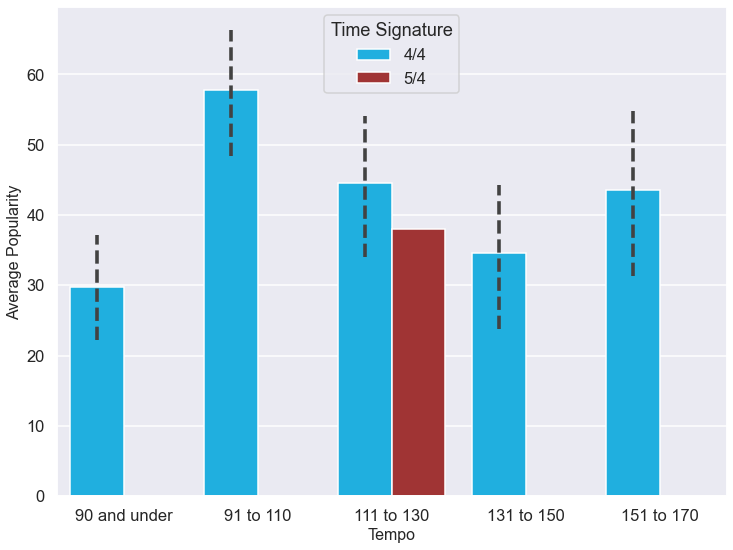

In [87]:
#houston_rap_viz = houston_rap.drop(houston_rap[houston_rap.time_signature == 0].index)
houston_rap_viz = houston_rap.rename(columns={"time_signature": "Time Signature"})
sns.barplot(x="tempo_bins", y="popularity", hue="Time Signature", data=houston_rap_viz)
plt.xlabel("Tempo", size=16)
plt.ylabel("Average Popularity", size=16)
plt.show()

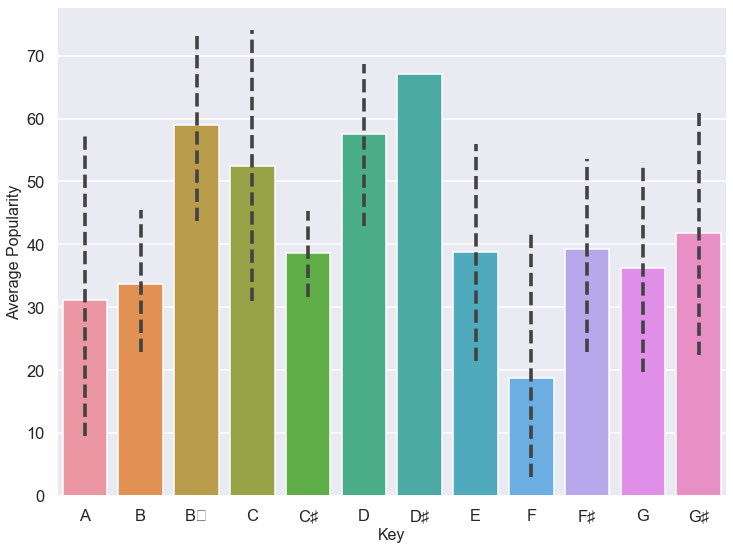

In [88]:
sns.barplot(x="key", y="popularity", data=houston_rap_viz.sort_values(by='key'))
plt.xlabel("Key", size=16)
plt.ylabel("Average Popularity", size=16)
plt.show()

In [254]:
houston_rap[houston_rap['mode'] == 'Major'].key.value_counts()
#houston_rap.key.value_counts()

C♯    28
B     11
G      8
D      7
G♯     5
F♯     4
A      3
C      2
E      1
Name: key, dtype: int64

I will drop tracks with keys D♯, A, G, and E because there are only one observation per mode in those keys.

Actually, I will drop tracks with keys A, F, C, and D# because there are very few observations in those keys.

In [249]:
houston_rap_viz[(houston_rap['key'] == 'D♯') | (houston_rap['key'] == 'D')]

,artist,album,track_name,popularity,key,mode,valence,tempo,Time Signature,explicit,album_type,duration_seconds,duration_minutes,is_featured_artist,popularity_bins,tempo_bins,valence_bins
track_id,,,,,,,,,,,,,,,,,
3yhhv0VCmKkAWD9ysDLpTE,megan thee stallion,good news,shots fired,71,D,Major,0.450,92.0285,4/4,1,album,170,2,0,Moderate,91 to 110,"(0.4, 0.6]"
05b94NgTfntKGZra5TMEcx,megan thee stallion,good news,intercourse (feat. popcaan & mustard),67,D♯,Minor,0.433,98.0170,4/4,1,album,197,3,1,Moderate,91 to 110,"(0.4, 0.6]"
769KncIWnBJwqWiywXoJ5a,megan thee stallion,make it hot,last week in h tx,51,D,Minor,0.601,102.4790,4/4,1,album,206,3,0,Moderate,91 to 110,"(0.4, 0.6]"
2GbS8QZToLioxL8XMEwX3P,megan thee stallion,tina snow,cognac queen,49,D,Major,0.260,131.0790,4/4,1,album,222,3,0,Moderate,131 to 150,"(-0.1, 0.4]"
0W7R5wlb4rjvowSPOY7c8m,megan thee stallion,good news,don’t stop (feat. young thug),68,D,Major,0.468,138.0270,4/4,1,album,187,3,1,Moderate,131 to 150,"(0.4, 0.6]"
2Xoc4gqPbBa3QHKpBLJ5l8,beatking,then leave (feat. queendome come),then leave (feat. queendome come),73,D,Major,0.491,140.9680,4/4,1,single,151,2,1,High,131 to 150,"(0.4, 0.6]"
3YEbLhXRDPTtctnb3ddg8g,megan thee stallion,tina snow,big ole freak,68,D,Major,0.627,142.9790,4/4,1,album,214,3,0,Moderate,131 to 150,"(0.4, 0.6]"
2qEP4c8KqVjnS3EEtoLjk9,paul wall,heart of a champion,showin' skillz (feat. lil keke),13,D,Major,0.323,151.2090,4/4,1,album,270,4,1,Low,151 to 170,"(-0.1, 0.4]"
1ZynYY8BPvWnx7t1EGwrPs,megan thee stallion,good news,outside,67,D,Major,0.713,168.0020,4/4,1,album,151,2,0,Moderate,151 to 170,"(0.6, 1.0]"


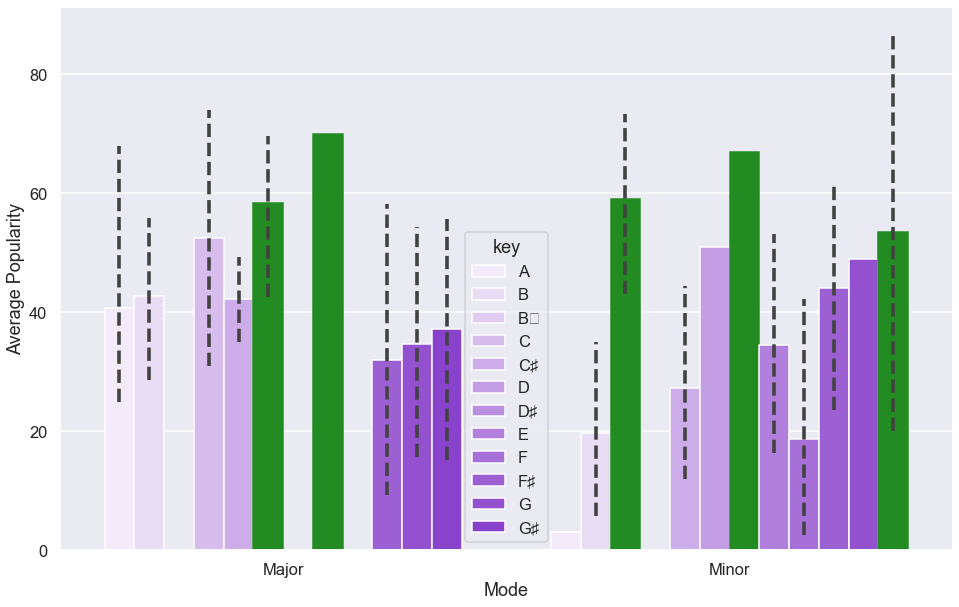

In [228]:
#clrs = ['red' if (x > (max(houston_rap.popularity))-40) else 'darkgreen' for x in houston_rap.popularity]
#, palette=clrs

ax = sns.barplot(x="mode", y="popularity", hue='key', color='blueviolet', data=houston_rap_viz.sort_values(by='key'))

for bar in ax.patches:
    if bar.get_height() > 53.4:
        bar.set_color('forestgreen')    
#    else:
#        bar.set_color('grey')

plt.xlabel("Mode", size=18)
plt.ylabel("Average Popularity", size=18)
plt.show()

In [ ]:
houston_rap.drop(columns)

E Major and D# Minor are the most popular key signatures in Houston Rap.

## Emo rap

In [90]:
# select only emo rap tracks
emo_rap = train[train['emo rap'] == 1]
# select only the features I will be using
emo_rap = emo_rap[['artist', 'album', 'track_name', 'popularity', 
                           'key', 'mode', 'valence', 'tempo', 'time_signature', 
                           'explicit', 'album_type', 'duration_seconds', 'duration_minutes',
                           'is_featured_artist', 'popularity_bins', 'tempo_bins', 'valence_bins']]
# save to csv for databricks import
#emo_rap.to_csv('emo_rap.csv')

In [91]:
emo_rap.head(6)

,artist,album,track_name,popularity,key,mode,valence,tempo,time_signature,explicit,album_type,duration_seconds,duration_minutes,is_featured_artist,popularity_bins,tempo_bins,valence_bins
track_id,,,,,,,,,,,,,,,,,
30bqVoKjX479ab90a8Pafp,lil peep,star shopping,star shopping,87,E,Minor,0.323,93.099,4/4,1,single,142,2,0,High,91 to 110,"(-0.1, 0.4]"
1YEwBpbhJ8KCNaQTGAL6mM,shattered,tell me that you miss me,tell me that you miss me,46,G♯,Major,0.201,99.847,4/4,1,single,211,3,0,Moderate,91 to 110,"(-0.1, 0.4]"
6NWl2m8asvH83xjuXVNsuG,lil xan,betrayed,betrayed,63,B♭,Minor,0.277,119.958,4/4,1,single,187,3,0,Moderate,111 to 130,"(-0.1, 0.4]"
7tUXZgLbOCvRJ9FBlairoU,ghostemane,blackmage,venom,68,F,Major,0.392,144.946,4/4,1,album,134,2,0,Moderate,131 to 150,"(-0.1, 0.4]"
16x9bQHw8TBNaGDyULvwad,xxxtentacion,?,before i close my eyes,70,A,Major,0.334,75.522,4/4,0,album,99,1,0,Moderate,90 and under,"(-0.1, 0.4]"
5hOnCHMwQdXOd4qfAWEhKP,city morgue,city morgue vol 2: as good as dead,draino (feat. denzel curry),62,C,Major,0.211,115.051,4/4,1,album,202,3,1,Moderate,111 to 130,"(-0.1, 0.4]"


In [92]:
emo_rap.shape

(164, 17)

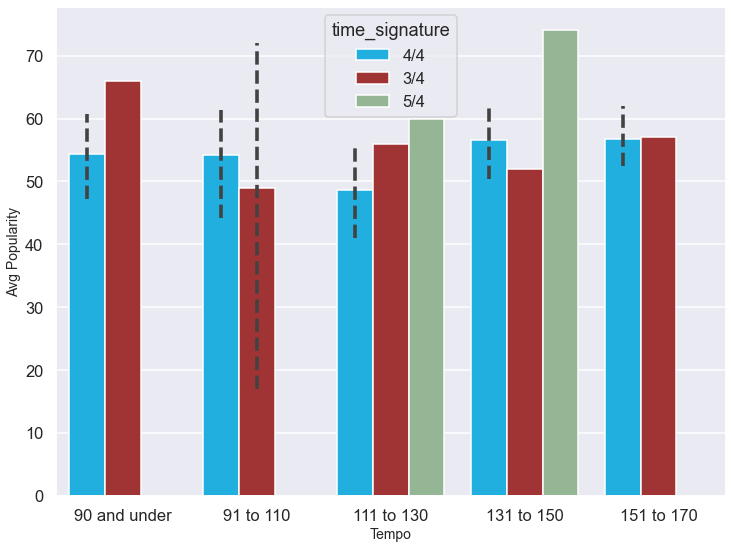

In [93]:
sns.barplot(x="tempo_bins", y="popularity", hue="time_signature", data=emo_rap.drop(emo_rap[emo_rap.time_signature == 0].index))
plt.xlabel("Tempo", size=14)
plt.ylabel("Avg Popularity", size=14)
plt.show()

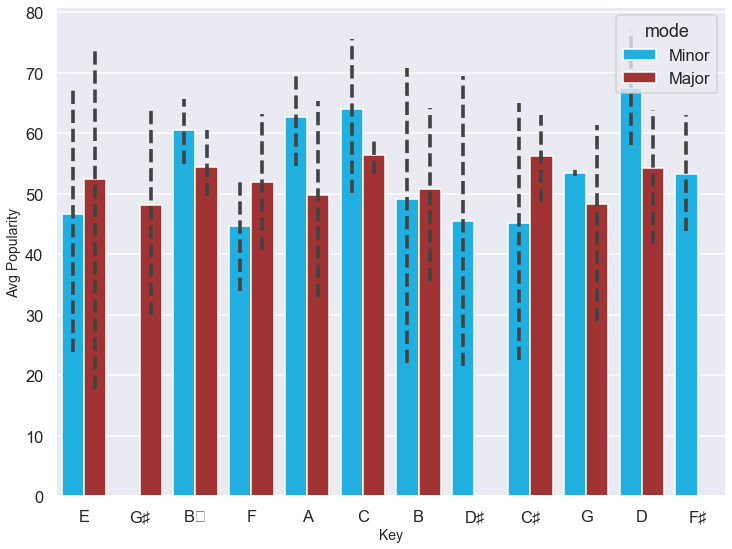

In [94]:
sns.barplot(x="key", y="popularity", hue="mode", data=emo_rap.drop(emo_rap[emo_rap.time_signature == 0].index))
plt.xlabel("Key", size=14)
plt.ylabel("Avg Popularity", size=14)
plt.show()

## Crunk

In [95]:
# select only crunk tracks
crunk = train[train['crunk'] == 1]
# select only the features I will be using
crunk = crunk[['artist', 'album', 'track_name', 'popularity', 
                           'key', 'mode', 'valence', 'tempo', 'time_signature', 
                           'explicit', 'album_type', 'duration_seconds', 'duration_minutes',
                           'is_featured_artist', 'popularity_bins', 'tempo_bins', 'valence_bins']]
# save to csv for databricks import
#crunk.to_csv('crunk.csv')

In [96]:
crunk.head(6)

,artist,album,track_name,popularity,key,mode,valence,tempo,time_signature,explicit,album_type,duration_seconds,duration_minutes,is_featured_artist,popularity_bins,tempo_bins,valence_bins
track_id,,,,,,,,,,,,,,,,,
3wAiorv2U7M87k512kUC5C,paul wall,the peoples champ,internet going nutz,25,A,Major,0.555,142.000,4/4,1,album,283,4,0,Low,131 to 150,"(0.4, 0.6]"
1OeTY85K4i1I7kNnvESfeb,gorilla zoe,welcome to the zoo,hood figga,31,C♯,Major,0.145,87.132,4/4,0,album,200,3,0,Low,90 and under,"(-0.1, 0.4]"
3SHDhuNfUcKZZVHwyoeevK,mystikal,let's get ready,jump,27,C♯,Minor,0.299,88.033,4/4,1,album,246,4,0,Low,90 and under,"(-0.1, 0.4]"
6naGRp5hPdsyIJo0yokznl,young dro,best thang smokin' (explicit version),rubberband banks,41,D,Major,0.852,156.162,4/4,1,album,289,4,0,Low,151 to 170,"(0.6, 1.0]"
5vPt9JXB0RQOAKahkvLrU1,three 6 mafia,da unbreakables (explicit version),put cha d. in her mouth - explicit album version,24,F♯,Minor,0.910,149.838,4/4,1,album,197,3,0,Low,131 to 150,"(0.6, 1.0]"
7kBdenpTmgWfAz9clmBcok,big tymers,i got that work,#1 stunna,47,G♯,Major,0.561,89.017,4/4,1,album,281,4,0,Moderate,90 and under,"(0.4, 0.6]"


In [97]:
crunk.shape

(147, 17)

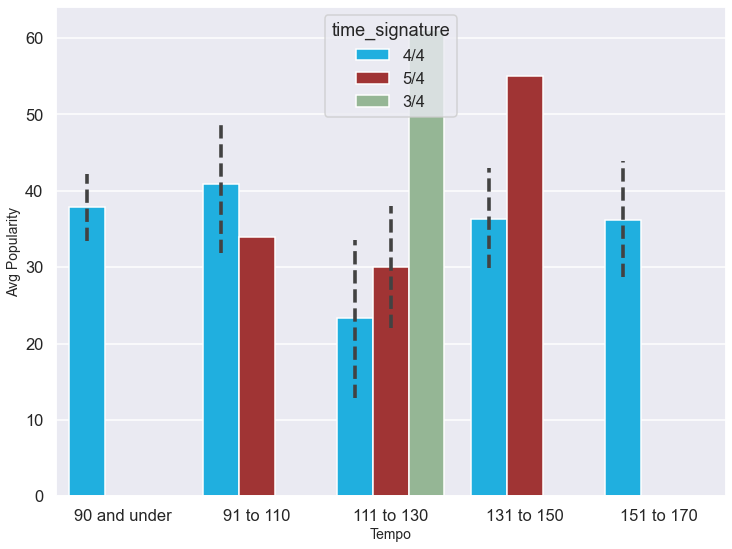

In [98]:
sns.barplot(x="tempo_bins", y="popularity", hue="time_signature", data=crunk.drop(crunk[crunk.time_signature == 0].index))
plt.xlabel("Tempo", size=14)
plt.ylabel("Avg Popularity", size=14)
plt.show()

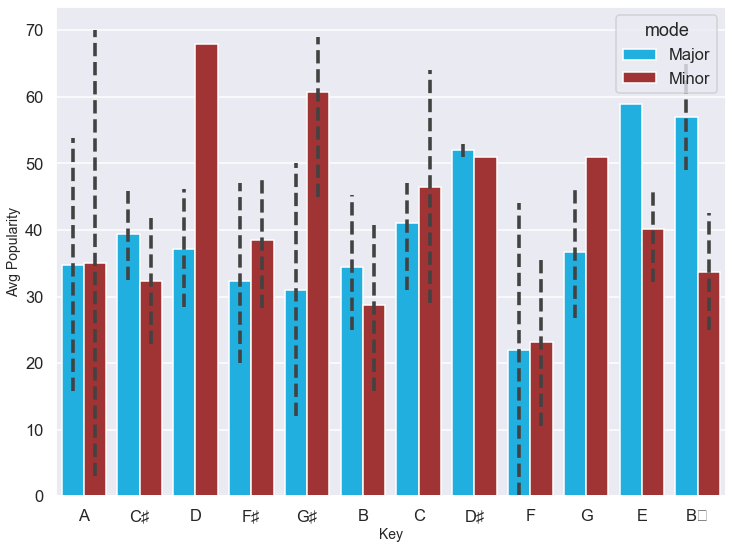

In [99]:
sns.barplot(x="key", y="popularity", hue="mode", data=crunk.drop(crunk[crunk.time_signature == 0].index))
plt.xlabel("Key", size=14)
plt.ylabel("Avg Popularity", size=14)
plt.show()

To-do tomorrow:
   * Make slides with the above visuals for the three genres.
   * Write 120-second presentation script to go over end of prepare and all of explore.

## What sub-genres are most popular?

In [100]:
# select genres to show on presentation
prez_genres = train[(train['houston rap'] == 1) | (train['trap'] == 1) | (train['southern hip hop'] == 1) | (train['emo rap'] == 1) | (train['lgbtq+ hip hop'] == 1) | (train['escape room'] == 1) | (train['crunk'] == 1)]
# select only the features I will be using
prez_genres = prez_genres[['artist', 'album', 'track_name', 'popularity', 
                           'key', 'mode', 'valence', 'tempo', 'time_signature', 
                           'explicit', 'album_type', 'duration_seconds', 'duration_minutes',
                           'is_featured_artist', 'popularity_bins', 'tempo_bins', 'valence_bins',
                          'houston rap', 'trap', 'southern hip hop', 'emo rap', 'lgbtq+ hip hop',
                          'escape room', 'crunk']]

In [101]:
genres = ['houston rap', 'trap', 'southern hip hop', 'emo rap', 'lgbtq+ hip hop', 'escape room', 'crunk']

In [102]:
for col in genres:
    pop_mean = prez_genres[prez_genres[col] == 1].popularity.mean()
    print('Avg popularity of', col + ':\n', round(pop_mean, 0), '\n  ---   ')

Avg popularity of houston rap:
 40.0 
  ---   
Avg popularity of trap:
 41.0 
  ---   
Avg popularity of southern hip hop:
 36.0 
  ---   
Avg popularity of emo rap:
 54.0 
  ---   
Avg popularity of lgbtq+ hip hop:
 33.0 
  ---   
Avg popularity of escape room:
 32.0 
  ---   
Avg popularity of crunk:
 37.0 
  ---   


In [103]:
genres = ['popularity', 'rap', 'pop rap', 'hip hop', 'trap queen', 'trap', 'southern hip hop', 'hip pop', 'dance pop', 'gangster rap', 'escape room',
          'pop', 'r&b', 'dirty south rap', 'underground hip hop', 'east coast hip hop', 'atl hip hop', 'hardcore hip hop', 'urban contemporary', 'pop r&b', 'lgbtq+ hip hop', 'dark trap', 'pop dance', 'queens hip hop',
          'emo rap', 'miami hip hop', 'crunk', 'melodic rap', 'post-teen pop', 'vapor trap', 'alternative r&b', 'chicago rap', 'alternative hip hop', 'houston rap']

In [104]:
for col in genres:
    pop_mean = train[train[col] == 1].popularity.mean()
    print('Avg popularity of', col + ':\n', round(pop_mean, 0), '\n  ---   ')

Avg popularity of popularity:
 1.0 
  ---   
Avg popularity of rap:
 41.0 
  ---   
Avg popularity of pop rap:
 38.0 
  ---   
Avg popularity of hip hop:
 40.0 
  ---   
Avg popularity of trap queen:
 30.0 
  ---   
Avg popularity of trap:
 41.0 
  ---   
Avg popularity of southern hip hop:
 36.0 
  ---   
Avg popularity of hip pop:
 26.0 
  ---   
Avg popularity of dance pop:
 38.0 
  ---   
Avg popularity of gangster rap:
 42.0 
  ---   
Avg popularity of escape room:
 32.0 
  ---   
Avg popularity of pop:
 47.0 
  ---   
Avg popularity of r&b:
 26.0 
  ---   
Avg popularity of dirty south rap:
 36.0 
  ---   
Avg popularity of underground hip hop:
 45.0 
  ---   
Avg popularity of east coast hip hop:
 37.0 
  ---   
Avg popularity of atl hip hop:
 44.0 
  ---   
Avg popularity of hardcore hip hop:
 40.0 
  ---   
Avg popularity of urban contemporary:
 31.0 
  ---   
Avg popularity of pop r&b:
 28.0 
  ---   
Avg popularity of lgbtq+ hip hop:
 33.0 
  ---   
Avg popularity of dark tr

In [105]:
most_popular_genres = train[['popularity', 'rap', 'pop rap', 'hip hop', 'trap queen', 'trap', 'southern hip hop', 'hip pop', 'dance pop', 'gangster rap', 'escape room',
      'pop', 'r&b', 'dirty south rap', 'underground hip hop', 'east coast hip hop', 'atl hip hop', 'hardcore hip hop', 'urban contemporary', 'pop r&b', 'lgbtq+ hip hop', 'dark trap', 'pop dance', 'queens hip hop',
      'emo rap', 'miami hip hop', 'crunk', 'melodic rap', 'post-teen pop', 'vapor trap', 'alternative r&b', 'chicago rap', 'alternative hip hop', 'houston rap']]

In [106]:
# default viz size settings
sns.set(rc={'figure.figsize':(14, 12)})
sns.set_context("talk", rc={"font.size":16,"axes.titlesize":16,"axes.labelsize":12}) 
plt.rc('figure', figsize=(14, 12))
plt.rc('font', size=16)
mpl.rcParams['font.size'] = 16
mpl.rcParams['figure.figsize'] = 16, 10
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '--'
mpl.rcParams['axes.prop_cycle'] = cycler(color=['deepskyblue', 'firebrick', 'darkseagreen', 'violet'])

In [107]:
genre_pops = pd.DataFrame([40, 41, 54, 33, 32, 37, 52, 58, 47],
                          ['Houston\nRap', 'Trap', 'Emo Rap', 'LGBTQ+\nHip Hop', 'Escape\nRoom', 'Crunk', 'Vapor Trap', 'Melodic\nRap', 'Post-Teen\nPop'], columns=['Average Popularity'])

genre_pops = genre_pops.sort_values(by="Average Popularity", ascending=False).T

genre_pops

,Melodic\nRap,Emo Rap,Vapor Trap,Post-Teen\nPop,Trap,Houston\nRap,Crunk,LGBTQ+\nHip Hop,Escape\nRoom
Average Popularity,58,54,52,47,41,40,37,33,32


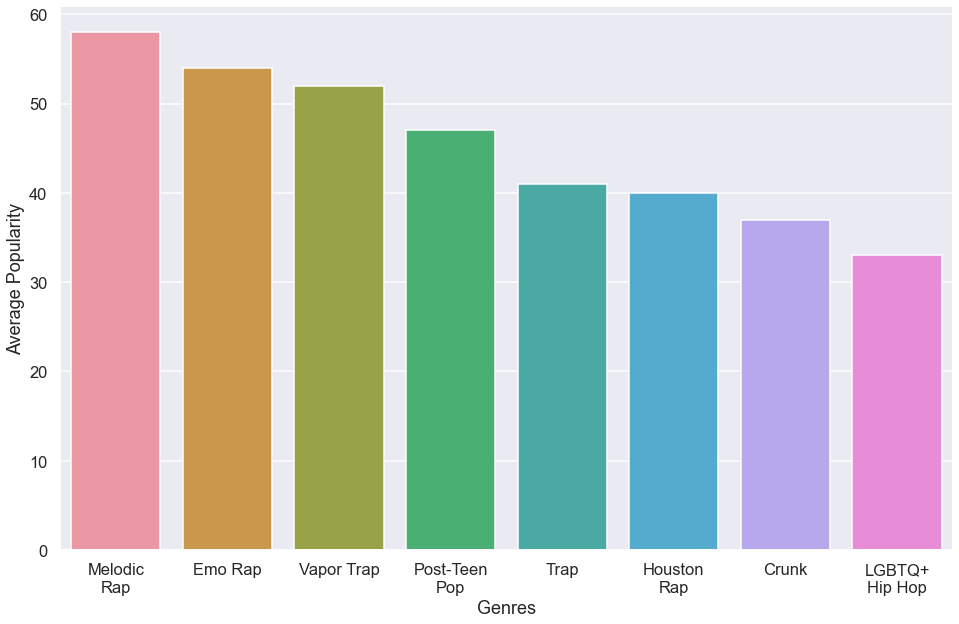

In [108]:
#genres_capitalized = ['Houston\nRap', 'Trap', 'Southern\nHip Hop', 'Emo Rap', 'LGBTQ+\nHip Hop', 'Escape\nRoom', 'Crunk']
#avg_pop = [40, 41, 36, 54, 33, 32, 37]
sns.barplot(data=genre_pops.drop(columns="Escape\nRoom"))
plt.xlabel("Genres", size=18)
plt.ylabel("Average Popularity", size=18)
plt.show()

In [109]:
most_popular_genres = train[['popularity', 'rap', 'pop rap', 'hip hop', 'trap queen', 'trap', 'southern hip hop', 'hip pop', 'dance pop', 'gangster rap', 'escape room',
      'pop', 'r&b', 'dirty south rap', 'underground hip hop', 'east coast hip hop', 'atl hip hop', 'hardcore hip hop', 'urban contemporary', 'pop r&b', 'lgbtq+ hip hop', 'dark trap', 'pop dance', 'queens hip hop',
      'emo rap', 'miami hip hop', 'crunk', 'melodic rap', 'post-teen pop', 'vapor trap', 'alternative r&b', 'chicago rap', 'alternative hip hop', 'houston rap']]

In [110]:
train[train['melodic rap'] == 1].artist.value_counts()

lil uzi vert              34
trippie redd               7
juice wrld                 6
6lack                      5
tory lanez                 4
young thug                 4
rich the kid               3
tyla yaweh                 3
flipp dinero               3
a boogie wit da hoodie     3
yfn lucci                  3
lil gnar                   3
lil mosey                  3
staysolidrocky             3
rae sremmurd               3
poorstacy                  3
gunna                      2
smokepurpp                 2
kodak black                2
yung tory                  2
lil skies                  2
nav                        2
lil yachty                 2
iann dior                  2
roddy ricch                2
saint jhn                  2
maxo kream                 1
yungeen ace                1
jaydayoungan               1
6 dogs                     1
oliver francis             1
quality control            1
lil tecca                  1
ion lil gut                1
ty james      